In [6]:
from openseespy.opensees import *
from math import asin, sqrt
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
# from second_fiber_section_creator import fibercreator
import openseespy.postprocessing.Get_Rendering as opp
# import pyvista as pv
# pv.set_jupyter_backend('ipyvtklink')

#output file format
# thre output files are formed
# '3ModalAnalysis_Node_EigenVectors_EigenVec1.out' will contain first mode shape
# '3ModalAnalysis_Node_EigenVectors_EigenVec2.out' will contain second mode shape
# '3ModalAnalysis_Node_EigenVectors_EigenVec3.out' will contain third mode shape
# '3DModalAnalysis_Node_EigenVectors_EigenVal.out' will contain natural frequequency and time period of each mode

In [7]:
def scattermodelplotter(nodes):
    fig=plt.figure(figsize=(10,7))
    ax=plt.axes(projection="3d")
    
    for node in nodes:
      ax.scatter3D(*node,color='green')
    plt.title("Model node location")
    plt.grid()
    plt.show()

In [8]:
wipe()
model("basic",'-ndm',3,'-ndf',6)
bayx=6.0
bayy=7.0
storey=3.5

#gridlines
x0=0.0
x1=6.0

y0=0.0
y1=7.0

z0=0.0
z1=3.5

#define nodes
na0=[x0,y0,z0]   #A
na1=[x0,y0,z1]

nb0=[x1,y0,z0]   #B
nb1=[x1,y0,z1]

nc0=[x0,y1,z0]   #C
nc1=[x0,y1,z1]

nd0=[x1,y1,z0]   #D
nd1=[x1,y1,z1]

nodes=[na0,na1,nb0,nb1,nc0,nc1,nd0,nd1]

for x,y in enumerate(nodes):
    node(x+1,*y)
# printModel("-node")
# scattermodelplotter(nodes)

###naming the node tags
na0=1
na1=2

nb0=3
nb1=4

nc0=5
nc1=6

nd0=7
nd1=8

fixpattern=[1]*6
fix(na0,*fixpattern)
fix(nb0,*fixpattern)
fix(nc0,*fixpattern)
fix(nd0,*fixpattern)


No Model_ODB specified, trying to get data from the active model.
3D model


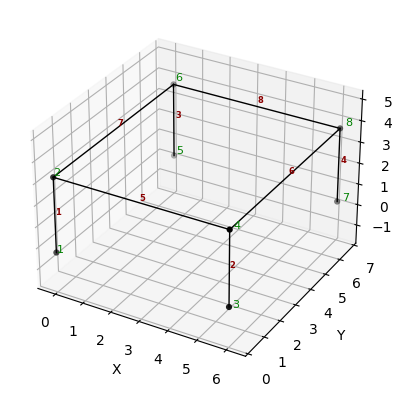

No Model_ODB specified to plot modeshapes
3D model


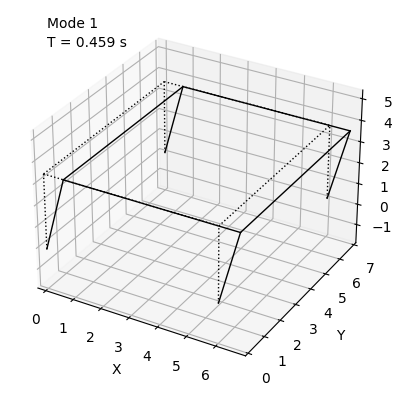

No Model_ODB specified to plot modeshapes
3D model


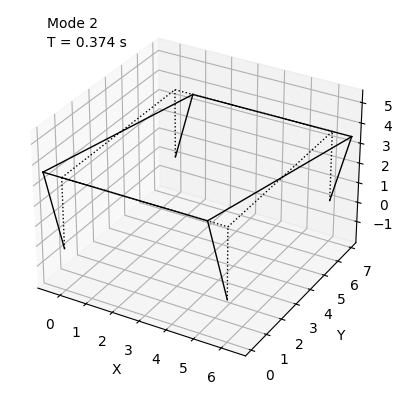

No Model_ODB specified to plot modeshapes
3D model


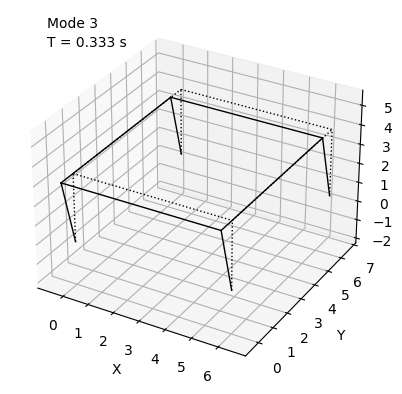

In [9]:
#define materials

#setting id of materials
C_concrete=1
unconfined_concrete=2
Rebar_steel=3

#parameters for models

fc1=-25000    #unconfined
fc2=-28000    #confined
epsc=-0.002   #strain at maximum stress in compression
fu1= 0.2*fc1  #ultimate for unconfined
fu2= 0.2*fc2  #ultimate for confined
epsu=-0.02    #strain at ultimate stress in comparison
lamba=0.1     #ratio between reloading stiffness and initial stiffness in compression
ft1=-0.1*fc1  #maximum stress in tension for unconfined concrete
ft2=-0.1*fc2  #maximum stress in tension for confined concrete
et1=ft1/0.002 #Elastic modulus in tension for unconfined concrete 
et2=ft2/0.002 #Elastic modulus in tension for confined concrete

# E in compression is calculated automatically depending on other material properties

fy=420000     #for reinforcing steel
Es=210000000; #E for reinforcing steel
b=0.005;      #strain hardening ratio
R0=20;        #smoothness of the elastic-to-plastic transition
cR1=0.925;    #smoothness of the elastic-to-plastic transition	
cR2=0.15;     #smoothness of the elastic-to-plastic transition  

#define concrete material
#uniaxialMaterial('Concrete02', matTag, fpc, epsc0, fpcu, epsU, lambda, ft, Ets)
uniaxialMaterial("Concrete02",C_concrete,fc1,epsc,fu1,epsu,lamba,ft1,et1)
uniaxialMaterial("Concrete02",unconfined_concrete,fc2,epsc,fu2,epsu,lamba,ft2,et2)

#define steel
#uniaxialMaterial('Steel02', matTag, Fy, E0, b, *params, a1=a2*Fy/E0, a2=1.0, a3=a4*Fy/E0, a4=1.0, sigInit=0.0)
uniaxialMaterial("Steel02",Rebar_steel,fy,Es,b,R0,cR1,cR2)

#define sections IDs
c300x400=1
b300x600=2

#Define dimensions                   
pi= np.pi          
Rebar_25=pi*0.025*0.025/4;  #area rebar 25mm
b_col=0.3; #column base
h_col=0.4; #column height
r_col=0.04; #column cover
b_beam=0.3; #beam base      
h_beam=0.6; #beam height
r_beam=0.04; #beam cover

def fibercreator(secID,Hsec,Bsec,
                 Confined_concrete,unconfined_concrete,Rebar_steel,
                 ch,cb,
                 ntop,areatop,nbot,areabot,ninterTotal,areainter,
                 nfcorey,nfcorez,nfcovy,nfcovz):
    
    coverY=Hsec/2.0
    coverZ=Bsec/2.0
    coreY=coverY-ch
    coreZ=coverZ-cb
    numBarsInt=int(ninterTotal/2)  #no. of intermediate bars per side 

    #    define fiber sections
    section("Fiber",secID,'-GJ',1000000000)
    
    #    define the core
    patch("quad",Confined_concrete,nfcorey,nfcorez,-coreY,coreZ,-coreY,-coreZ,coreY,-coreZ,coreY,coreZ)

    #    define the four cover patches
    patch("quad",unconfined_concrete,2,nfcovy,-coverY,coverZ,-coreY,-coreZ,coreY,coreZ,coverY,coverZ)
    patch("quad",unconfined_concrete,2,nfcovy,-coreY,-coreZ,-coverY,-coverZ,coverY,-coverZ,coreY,-coreZ)
    patch("quad",unconfined_concrete,nfcovz,2,-coverY,coverZ,-coverY,-coverZ,-coreY,-coreZ,-coreY,coreZ)
    patch("quad",unconfined_concrete,nfcovz,2,coreY,coreZ,coreY,-coreZ,coverY,-coverZ,coverY,coverZ)

    #    define reinforcing layers
    layer("straight",Rebar_steel,numBarsInt,areainter,-coreY,coreZ,coreY,coreZ)
    layer("straight",Rebar_steel,numBarsInt,areainter,-coreY,-coreZ,coreY,-coreZ)
    layer("straight",Rebar_steel,ntop,areatop,coreY,coreZ,coreY,-coreZ)
    layer("straight",Rebar_steel,nbot,areabot,-coreY,coreZ,-coreY,-coreZ)

#BuildRCrectSection	$ColSecTag   $HSec   $BSec   $coverH  $coverB  $IDconcCore $IDconcCover $IDSteel $numBarsTop $barAreaTop $numBarsBot $barAreaBot $numBarsIntTot $barAreaInt $nfCoreY  $nfCoreZ  $nfCoverY  $nfCoverZ
fibercreator(c300x400,h_col,b_col,
             C_concrete,unconfined_concrete,Rebar_steel,
             r_col,r_col,
             3,Rebar_25,4,Rebar_25,4,Rebar_25,
             8,8,8,8)
 
fibercreator(b300x600,h_beam,b_beam,
             C_concrete,unconfined_concrete,Rebar_steel,
             r_beam,r_beam,
             3,Rebar_25,4,Rebar_25,4,Rebar_25,
             8,8,8,8)

#define transformation tag
PDtranscol=1
LtransbeamX=2
LtransbeamY=3

NI=8 #number of integration points

#Definition of transformation
geomTransf('PDelta',PDtranscol,-1,0,0)
geomTransf('Linear',LtransbeamX,0,1,0)
geomTransf('Linear',LtransbeamY,1,0,0)

element('nonlinearBeamColumn',1,na0,na1,NI,c300x400,PDtranscol)
element('nonlinearBeamColumn',2,nb0,nb1,NI,c300x400,PDtranscol)
element('nonlinearBeamColumn',3,nc0,nc1,NI,c300x400,PDtranscol)
element('nonlinearBeamColumn',4,nd0,nd1,NI,c300x400,PDtranscol)

element('nonlinearBeamColumn',5,na1,nb1,NI,b300x600,LtransbeamX)
element('nonlinearBeamColumn',6,nb1,nd1,NI,b300x600,LtransbeamY)
element('nonlinearBeamColumn',7,na1,nc1,NI,b300x600,LtransbeamY)
element('nonlinearBeamColumn',8,nc1,nd1,NI,b300x600,LtransbeamX)

#Gravity loads
timeSeries('Linear',1)
CL=80 #KN

pattern('Plain',1,1)
load(na1,0,0,-CL,0,0,0)
load(nb1,0,0,-CL,0,0,0)
load(nc1,0,0,-CL,0,0,0)
load(nd1,0,0,-CL,0,0,0)

#masses
mass1=200 #tonf

#assign masses
mass(na1,mass1/4,mass1/4,0,0,0,0)
mass(nb1,mass1/4,mass1/4,0,0,0,0)
mass(nc1,mass1/4,mass1/4,0,0,0,0)
mass(nd1,mass1/4,mass1/4,0,0,0,0)

NumberOfModes=3   #i don't know exactly but i think it can only solve for (number of nodes with inertial masses-1) modes.
opp.createODB("3D_frame",'trial',Nmodes=NumberOfModes)
opp.plot_model('nodes','element','3D_frame') #plots nodes,elements in 3D
for n in range(1,NumberOfModes+1):
    opp.plot_modeshape(n,10)

In [10]:
#setup recorders for gravity analysis

recorder('Node','-file','3ModalAnalysis_Node_EigenVectors_EigenVec1.out','-time','-node',na1,nb1,nc1,nd1,'-dof',1,2,'eigen 1')
recorder('Node','-file','3ModalAnalysis_Node_EigenVectors_EigenVec2.out','-time','-node',na1,nb1,nc1,nd1,'-dof',1,2,'eigen 2')
recorder('Node','-file','3ModalAnalysis_Node_EigenVectors_EigenVec3.out','-time','-node',na1,nb1,nc1,nd1,'-dof',1,2,'eigen 3')


constraints('Transformation')
numberer('Plain')
system('BandGen')
test('NormDispIncr',+1.00E-12,25,0,2)
algorithm('Newton')
integrator('Newmark',+5.000000E-01,+2.500000E-01)
analysis('Transient')

PI = 2 * asin(1.0)
eigFID= open("3DModalAnalysis_Node_EigenVectors_EigenVal.out","w")
omega_square_list=eigen(3)             #use eigen() function to calculate two eigen values
eigFID.write("lambda omega period frequency\n")
for x in omega_square_list:
 omega=sqrt(x)
 period=2.0*PI/omega
 frequency=1.0/period
 eigFID.write(f"{x:+.6e} {omega:+.6e} {period:+.6e} {frequency:+.6e}\n")
eigFID.close()

record()

setTime(0.0) 
loadConst() 
remove('recorders') 
wipeAnalysis()
